# ROE选股

- 作者：DGC'Idea
- 版本：V0.1   
- 更新日期：2018年4月6日

----------
- 上市满五年，近五年每年ROE>15，近五年平均ROE>20；或者，上市满三年，近三年每年ROE>20；
- 除医药消费，其他行业只选一家（业内要么第一、要么唯一）；
- 有持续良好的经营历史及持续的分红，剔除创业板及ST；
- 近三年净利润复合增长必须为正，按近五年均ROE降序选出20家企业。

In [1]:
#导入库
import numpy as np
import pandas as pd
import time
from datetime import timedelta,date

import jqdata

#引入自定义库
import sys
sys.path.append('/home/jquser')

from pf_stk import *
from vd_stk import stkView 

roe20=Stk('csv','../Data/','roe20') 
view=stkView(roe20,u'ROE20股票')   




数据引擎：运行于研究
个股框架：运行于研究


### 1.1.生成股票池

In [2]:
#股票池筛选函数
def pool(index='000016.XSHG',stat_year=2017,max_year=5):
    #初选股票池列表
    pool=[]
    #获取沪深所有股票
    stocks=get_index_stocks(index)
    #股票总数量
    n=len(stocks)
    #计数器
    m=0
    for code in stocks:
        #计数器累加
        m=m+1
        #股票名称
        stock_name=get_security_info(code).display_name       
        #转换代码
        stock_code=code[0:6]
        #IPO日期
        ipo_date = get_security_info(code).start_date
        #转换ipo日期
        ipo_year=int(ipo_date.strftime('%Y'))
        #显示进度
        print '\r股票筛选：%s %s %s/%s'%(stock_code,stock_name,m,n),
        #剔除创业板
        if is_cyb(code):
            continue
        #剔除退市、ST
        if is_st(code):
            continue
        #剔除未满3年   
        if stat_year-ipo_year<2:
            continue    
        #判断是否已出最新年报    
        if not is_report(code,stat_year):
            continue         
        #入选标记
        isfind=False   
        #上市满5年（具有完整的最近5年年报数据）
        if stat_year-ipo_year>=4:
            #roe、毛利率、营业收入复合增长率、利润复合增长率
            (roe,roe_mean,gross_profit,inc_revenue,net_profit,new_profit,df)=get_stock_indicator(code,
                                             stat_year,max_year,5)
            #每年ROE>15,平均ROE>20
            if len(df[df.inc_return>=15.0])>=5 and roe_mean>=20:
                isfind=True
        #或者上市满3年（具有完整的最近3年年报数据）         
        elif stat_year-ipo_year>=2:
            #roe、毛利率、营业收入复合增长率、利润复合增长率
            (roe,roe_mean,gross_profit,inc_revenue,net_profit,new_profit,df)=get_stock_indicator(code,
                                               stat_year,max_year,3)
            #每年ROE>20
            df=df[0:3]
            if len(df[df.inc_return>=20.0])>=3:
                isfind=True
        #剔除利复增为负  
        if net_profit<=0.00 :
            continue  
        #剔除最新为负  
        if new_profit<=0.00 :
            continue      
        #如果入选，则添加、整理数据
        if isfind : 
            #获取roe列表
            roe_list=df['inc_return'].tolist()
            #不满5年的数据填充为NAN
            for i in range(max_year-len(df)):
                roe_list=[float('NAN')]+roe_list  
            #获取所属行业名称
            industry=get_stock_industry(code)
            #拼接列表
            pool.append([code,stock_name]+roe_list+
                             [roe_mean,gross_profit,inc_revenue,net_profit,industry,ipo_date]) 
    #整理标题头
    columns=['code','name']+['%s'%str(stat_year-max_year+1+y) for y in range(0,max_year)]+['roe_mean',
                  'gross_profit','revenue_grow','profit_grow','industry','ipo_date']
    #组织数据
    df=pd.DataFrame(data=pool,columns=columns)
    #设置索引为股票代码
    df.set_index(['code'],inplace=True)
    df.index.name=None
    #返回结果
    df=df.sort(['roe_mean'],ascending=False)    
    return df


#传入筛选函数
#roe20.pool.create_form(pool,index='000902.XSHG',stat_year=2017,max_year=5)


### 1.1.查看股票池

In [2]:
roe20.pool.show()

,名称,2013,2014,2015,2016,2017,ROE均(%),毛利率(%),营复增(%),利复增(%),所属行业,IPO日期
600816,安信信托,23.6608,29.3201,40.2289,77.0511,30.5931,40.17,NaN,69.69,118.21,非银金融I,1994-01-28
600340,华夏幸福,26.4889,30.8538,38.9368,42.3078,49.0915,37.54,47.93,39.17,37.74,房地产I,2003-12-30
002415,海康威视,33.5871,33.3961,32.8771,34.3956,30.0230,32.86,44.00,42.70,34.94,电子I,2010-05-28
002714,牧原股份,NaN,NaN,25.7683,50.1497,20.8308,32.25,29.81,60.36,311.51,农林牧渔I,2014-01-28
000651,格力电器,35.4439,30.7747,26.8638,35.9303,29.0508,31.61,32.86,10.57,26.80,家用电器I,1996-11-18
600519,贵州茅台,33.1303,24.7839,26.6144,32.3174,40.2531,31.42,89.80,18.25,17.19,食品饮料I,2001-08-27
600566,济川药业,28.6505,28.5185,25.8164,27.7510,43.8692,30.92,84.95,24.08,39.53,医药生物I,2001-08-22
603288,海天味业,NaN,NaN,31.0903,29.5027,30.0437,30.21,45.69,14.14,19.19,食品饮料I,2014-02-11
000049,德赛电池,22.8735,23.0483,25.2870,34.2157,44.4074,29.97,8.80,32.29,16.81,电子I,1995-03-20
000688,建新矿业,22.5686,15.4133,21.0746,29.5667,60.9078,29.91,57.72,15.25,16.55,有色金属I,1997-01-20


## 2.数据获取、分析
1. 设置当前股票池，以下数据获取和分析皆是针对当前股票池。
1. 获取行业列表，用于对股票进行行业分类；
2. 获取股票日线数据，包括行情数据、估值数据。

- 估值分析：PE-TTM（滚动市盈率）、PB（平均市净率）；
- 财务指标分析：毛利率、ROE（年报、扣非后净资产收益率）、近五年或三年的平均ROE、近三年营业收入复合增长率、近三年净利润复合增长率、股息率、PEG。

In [2]:
# roe20.data.update(roe20.pool.track)
roe20.value.update(roe20.pool.track,[5,3,1],force=True)
#roe20.change.update(roe20.pool.track,['close','pe','pb'],force=True)

数据分析：股票估值，分析完毕 ] 数据 


## 3.估值表
- PE-TTM：滚动市盈率，为近五年的数据；
- 高度：表示时间窗内（五年），低于当前值的个数与全部样本个数的比例，代表当前值在历史统计值的估值位置；
- 最小值：表示时间窗内（五年）理论最小估值，表示其估值下限；
- 最大值：表示时间窗内（五年）理论最大估值，表示其估值上限；
- 中位数：表示时间窗内（五年），代表该指数的理论合理估值；
- 距底：表示当前值与最低值的距离，代表最大的可能跌幅。 

In [2]:
view.table()

,名称,PE,PE高度,PB,PB高度,毛利率,ROE,ROE均,营复增,利复增,股息率,PEG,所属行业
603288,海天味业,52.60,87.40,18.54,87.40,45.69,35.25,32.34,14.82,21.92,1.16,2.40,食品饮料I
000688,建新矿业,30.17,80.49,5.58,32.52,57.72,18.50,20.02,15.25,16.55,0.88,1.82,有色金属I
002714,牧原股份,30.05,78.86,5.69,58.13,29.81,18.95,23.48,52.13,215.23,1.46,0.14,农林牧渔I
002032,苏泊尔,29.51,77.64,8.05,84.15,29.56,27.27,25.63,15.62,22.82,1.38,1.29,家用电器I
000963,华东医药,36.44,76.02,8.27,91.06,26.12,22.68,21.59,13.83,30.76,1.01,1.18,医药生物I
002304,洋河股份,27.46,72.76,6.94,91.87,66.46,25.27,23.23,3.40,2.55,1.90,10.77,食品饮料I
600276,恒瑞医药,77.29,72.36,16.17,78.86,86.63,20.93,20.61,20.62,24.82,0.14,3.11,医药生物I
000661,长春高新,50.41,70.33,8.42,89.02,81.94,16.70,14.74,19.03,18.05,0.37,2.79,医药生物I
600566,济川药业,28.90,59.76,10.31,93.90,84.95,35.67,30.70,24.08,39.53,2.00,0.73,医药生物I
002372,伟星新材,25.88,54.88,7.60,84.55,46.72,29.36,27.14,16.08,28.49,2.61,0.91,建筑材料I


## 4.行情

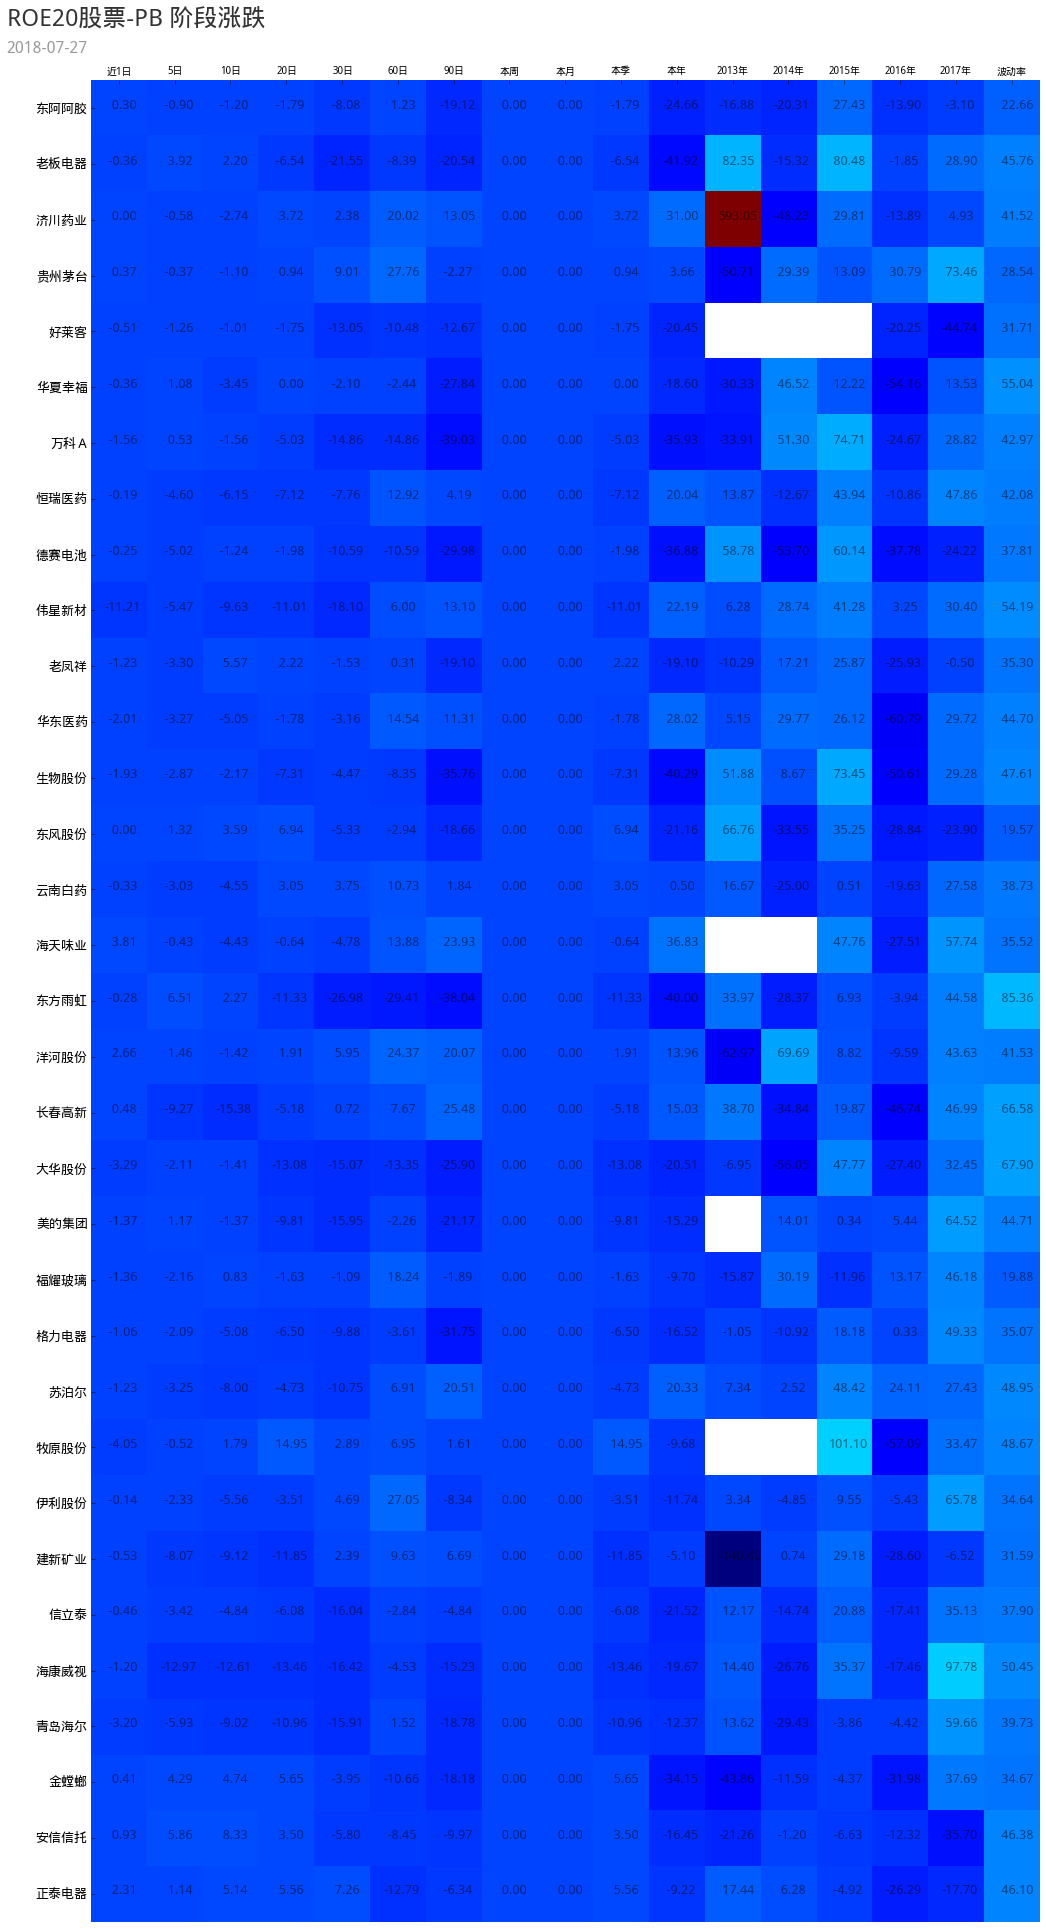

In [3]:
view.change()

## 5.走势图

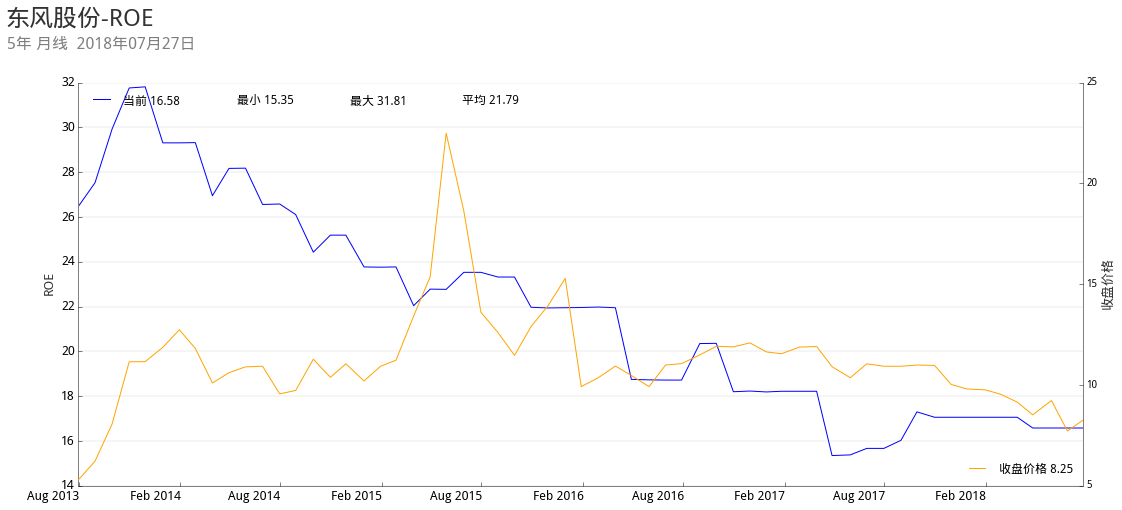

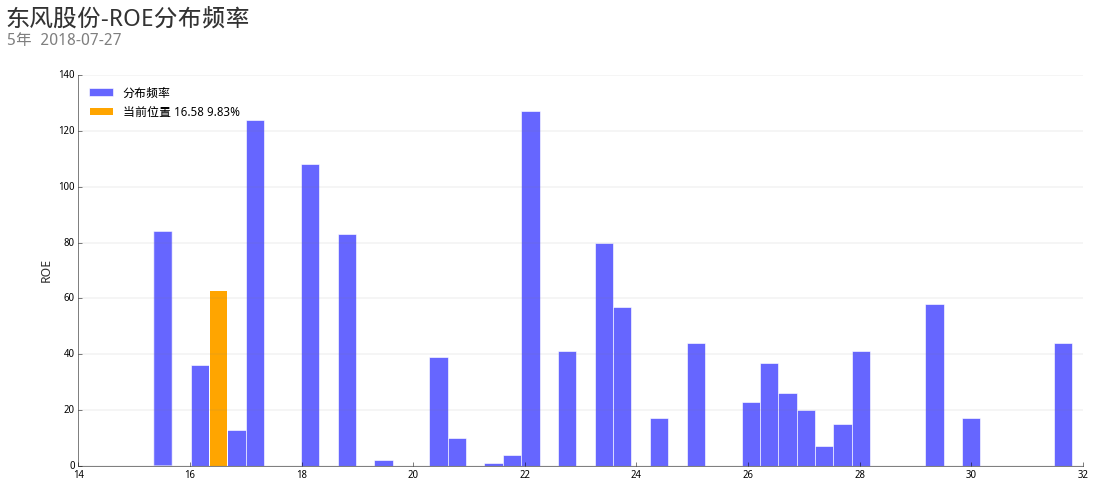

In [2]:
view.line_one()

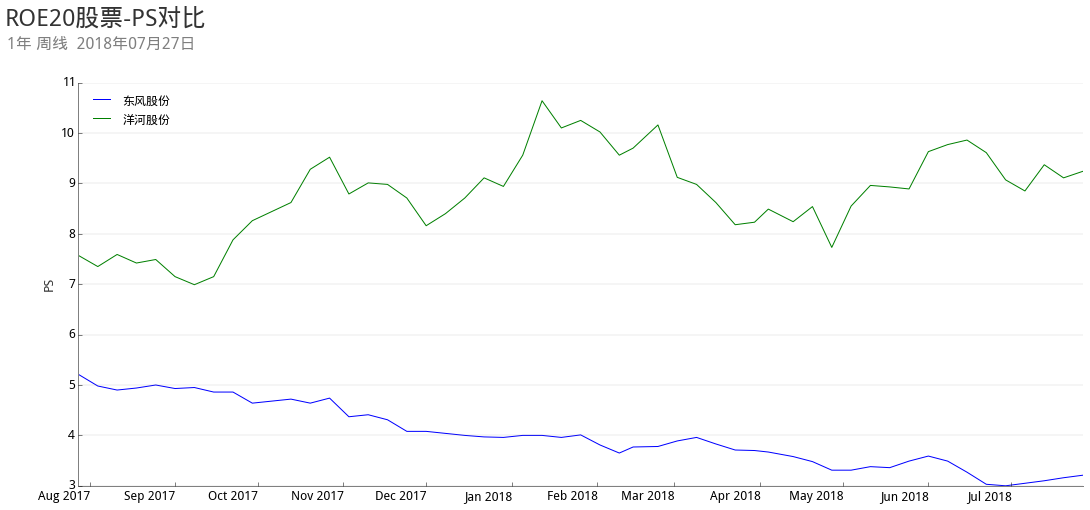

In [2]:
view.line_compar()